 # EKG Project

Given a sequence $F$ that is periodic or nearly periodic, we would like to find its period. We start with the observation that if a sequence $F$ has period $p$, for all integers $k$ we have
$$
     (F_k - F_{k+p})^2 = 0.
$$
Summing this over $k$ from zero to any integer $N-1$ gives
$$
     \sum_{k=0}^{N-1} (F_k - F_{k+p})^2 = 0.
$$
For a given sequence $F$, this is an equation to solve for the period $p$. Of course one solution to the equation is $p = 0$, but we need a nonzero solution to find the period. Since $\sum_{k=0}^{N-1} (F_k - F_{k+p})^2 \geq 0$ for all integers $p$, we are looking for the integer that _minimizes_ this sum. So this this a minimization problem.

Presumably if $F$ is nearly periodic, the number $p$ that minimizes the sum $\sum_{k=0}^{N-1} (F_k - F_{k+p})^2 = 0$ is in some sense an approximate period. But we haven't attempted to define _nearly periodic_.

To find the minimum, we'll use the Julia package https://github.com/JuliaNLSolvers/Optim.jl/

In [1]:
using LinearAlgebra

In [2]:
using Gadfly

In [3]:
using Optim

In [4]:
using Memoize

In [5]:
using Random

In [6]:
using Interpolations

In [7]:
using Dierckx

In [8]:
rng = MersenneTwister(0);

In [9]:
"""
For an array `a` and integers `n` and `N,` the call `Q(a,n,N)` returns `sum((a[k] - a[k+n])^2,k,1,N)`. This is a
memoizing function.
"""
function Q(a,n,N) 
    a = a[1:N] - a[n+1:n+N]
    dot(a,a)
end

Q

Notice the documentation string--we like them:

In [10]:
? Q

search: Q QR qr qr! quote QuoteNode QuickSort QRPivoted Quadratic LQ lq lq! sqrt



For an array `a` and integers `n` and `N,` the call `Q(a,n,N)` returns `sum((a[k] - a[k+n])^2,k,1,N)`. This is a memoizing function.


Let's test our theory.  We'll generate a sequence that is nearly period (or period) and look at the graph of $Q$. Here is our first example. The sequence is generated with a triangular wave. Its period is 200:

In [11]:
range1 = 0:999;

In [12]:
L = [asin(sin(pi*k/100)) + 0.6*asin(sin(pi*k/50))+ 0.2*randn(rng, Float64) for k in range1];

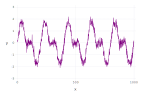

In [13]:
plot(x=range1,y=L, Geom.line, color=[colorant"purple"])

Generate the sequence we called $Q$. Well use $N$ = 50. That's 1/4 of a period. The graph of $Q$ should have minima at 0,200, 400, 600, ...

In [14]:
range2 = 0:600;

In [15]:
LL = [Q(L,k,50) for k in range2];

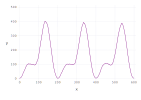

In [16]:
plot(x=range2,y=LL, Geom.line, color=[colorant"purple"])

Here is the function we need to minimize:

In [17]:
function mimimize_me(x)
   Q(L, convert(Int64, round(x)), 150)
end

mimimize_me (generic function with 1 method)

Instead of rounding $x$ to the nearest integer, I think we should linearly interpolate between $\lfloor x \rfloor$ and $\lceil x \rceil$. 

Let's look for a minimum in the interval $[100,300]$.

In [18]:
result = optimize(mimimize_me, 100, 300)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [100.000000, 300.000000]
 * Minimizer: 2.017873e+02
 * Minimum: 1.227464e+01
 * Iterations: 32
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 33

Looks like we found the period:

In [19]:
Optim.minimizer(result)

201.78732958903555

To linearly interpolate, we can do this

In [20]:
function mimimize_meto(x)
    x1 = convert(Int64, floor(x))
    x2 = convert(Int64, ceil(x))
    y1 = Q(L, x1, 150)
    y2 = Q(L, x2, 150)
    y1 + (y2-y1)*(x-x1)/(x2-x1)
end

mimimize_meto (generic function with 1 method)

In [21]:
result = optimize(mimimize_meto, 100, 300)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [100.000000, 300.000000]
 * Minimizer: 1.990000e+02
 * Minimum: 1.128470e+01
 * Iterations: 37
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 38

In [22]:
Optim.minimizer(result)

199.000002280718

Alternatively, we can expand `Q`
$$
     Q(n) = \sum_{k=0}^{N-1} (F_k - F_{k+n})^2 = 0.
$$
Thus
$$
  Q(n) = \sum_{k=0}^{N-1} F_k^2  - 2 \sum_{k=0}^{N-1} F_k F_{k+n} +  - \sum_{k=0}^{N-1} F_{k+n}^2
$$
The middle term, that is the sequence
$$
   n \mapsto \sum_{k=0}^{N-1} F_k F_{k+n}
$$
is an the _autocorrelation_ sequence for $F$. It has lots of nice properties; see https://en.wikipedia.org/wiki/Autocorrelation

We will model one period of a ecg as a piecewise linear function. We start with a function that does linear interpolation of two points in the plane, and then we build a function for defining a piecewise linear function.

In [23]:
"""
 Return the number `y` such that `(x,y)` is on the line that contains the points `(x0,y0)` and `(x1,y1)`.
"""
function linear_interpolation(x0::Real,x1::Real,y0::Real,y1::Real,x::Real)
    y0 + (y1-y0)*(x-x0)/(x1-x0)
    #fma((y1 - y0), ((x / (x1 - x0)) - (x0 / (x1 - x0))), y0)
end;

In [24]:
function qrs_complex(t0::Real, t1::Real,t2::Real,t3::Real, t4::Real, t5::Real, t6::Real, 
                     e0::Real, e1::Real,e2::Real,e3::Real, e4::Real, e5::Real, e6::Real, t::Real)
     t = mod(t, t6)     
    if t <= t1
        linear_interpolation(t0,t1,e0,e1,t)
    elseif t <= t2
         linear_interpolation(t1,t2,e1,e2,t)
    elseif t <= t3
         linear_interpolation(t2,t3,e2,e3,t) 
    elseif t <= t4
         linear_interpolation(t3,t4,e3,e4,t) 
    elseif t <= t5
         linear_interpolation(t4,t5,e4,e5,t)   
    else
         linear_interpolation(t5,t6,e5,e6,t)       
    end
end

qrs_complex (generic function with 1 method)

In [124]:
f = t ->  qrs_complex(0,1/6,2/6,3/6,4/6,5/6,6/6, 0,0,-2,10,-4,0,0,t)

#91 (generic function with 1 method)

In [26]:
g = t ->  f(t) + 0.2*randn(rng, Float64)

#7 (generic function with 1 method)

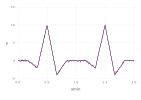

In [125]:
plot(layer(f, 0,2, color=[colorant"black"]), layer(g, 0,2, color=[colorant"purple"]))

Can we still find the period using our scheme?

In [28]:
range2 = 0:10^4

0:10000

In [29]:
N = 300;

In [30]:
range1 = 0:2*N;

In [31]:
L = [f(k/N) for k in range1];

In [32]:
LL = [g(k/N) for k in range1];

In [33]:
LLL = [Q(LL,n,100) for n in 0:500];

This graph should have minima at 100, 200, 300, .... And it does

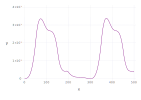

In [34]:
plot(x=1:500, y=LLL[1:500],Geom.line,color=[colorant"purple"])

In [35]:
function mimimize_meto(x)
    x1 = convert(Int64, floor(x))
    x2 = convert(Int64, ceil(x))
    y1 = Q(LL, x1, 50)
    y2 = Q(LL, x2, 50)
    linear_interpolation(x1,x2,y1,y2,x)
end

mimimize_meto (generic function with 1 method)

In [36]:
result = optimize(mimimize_meto, 10, 550);

In [37]:
Optim.minimizer(result)

288.9999999949991

In [38]:
xs = 0 : 0.05 : 1

0.0:0.05:1.0

In [39]:
map(g,xs);

In [40]:
fn = CubicSplineInterpolation(xs, map(g,xs));

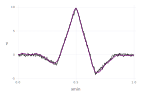

In [41]:
plot(layer(x -> fn(x),0,1,Geom.line, color=[colorant"purple"]), 
     layer(x -> g(x),0,1,Geom.line, color=[colorant"black"]))

In [42]:
function smooth(a,w0,w1,w2)
    w0*circshift(a,(-1)) + w1*a + w2*circshift(a,(1))   
end

smooth (generic function with 1 method)

In [126]:
N =  1024

1024

In [127]:
xs = [k for k in 0:N];

In [129]:
ys = [f(x/N) for x in xs];

In [95]:
ysmooth = smooth(ys,1/3,1/3,1/3);

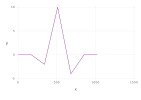

In [130]:
plot(x=xs,y=ys,Geom.line, color=[colorant"purple"])

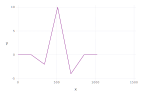

In [97]:
plot(x=xs,y=ysmooth,Geom.line, color=[colorant"purple"])

In [131]:
spl = Spline1D(xs, ys, k = 5, s=0.1)

Spline1D(knots=[0.0,128.0 … 896.0,1024.0] (38 elements), k=5, extrapolation="nearest", residual=0.09998237169786492)

In [134]:
spl.fp

0.09998237169786492

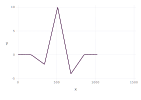

In [135]:
plot(layer(t -> spl(t), 0,N,color=[colorant"black"]), layer(x=xs,y=ysmooth,Geom.line, color=[colorant"purple"]))

In [136]:
function curvature(t)
    abs(derivative(spl,t,nu=2))/(1 + derivative(spl,t,nu=1)^2)^(3/2)
end

curvature (generic function with 1 method)

In [137]:
yys = [spl(t) for t in xs];

In [138]:
dyys =  [abs(derivative(spl, t; nu=2)) / (1 + derivative(spl, t; nu=1)^2)^(3/2) for t in xs];

In [140]:
sort(dyys, lt = (a,b)-> a>b)[1:16]

16-element Array{Float64,1}:
 0.033985476218669056
 0.03052825916748397
 0.03048766859737043
 0.022222427959552107
 0.022166207774739956
 0.019002412392592653
 0.016686235885362142
 0.01617813809577705
 0.015708437721830545
 0.01397061434479654
 0.012855625731416307
 0.012225180752451065
 0.012179673636098813
 0.011782336113552918
 0.011085852712178568
 0.009872945198233713

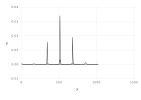